# Quality Control

Here are some steps to exclude poor quality samples and lowly expressed genes.

Let's load the raw expression data quantified by Kallisto:

In [1]:
setwd(here::here())
source("R/001_libraries_data.R")

Loading required package: pacman
load(data/gene_sets.rda)
load(data/rnaseq_kallisto_ensembl89.rda)
load(data/rnaseq-sirna_kallisto_ensembl89.rda)
fread('gunzip -c %s')data-raw/ensembl89/Homo_sapiens.GRCh38.89.gene_names.tsv.gz
library(tftargets)


The official name for one gene is `C15orf48`, but the more informative name is `NMES1`.

In [2]:
# Replace uninformative gene symbols.
gene_symbols[which(gene_symbols == "C15orf48")] <- "NMES1"

Let's define some helper functions and set the plotting theme for this notebook.

In [3]:
source("R/002_helper_functions.R")

In [4]:
theme_set(theme_classic(base_size = 14) %+replace% theme(
  axis.line.y = element_line(colour = "black", size = 0.2),
  axis.line.x = element_line(colour = "black", size = 0.2),
  axis.ticks = element_line(colour = "black", size = 0.2),
  strip.background = element_rect(size = 0.25)
))

In [5]:
# Useful functions for mixtools
sdnorm <- function(x, mean = 0, sd = 1, lambda = 1){
  lambda * dnorm(x, mean = mean, sd = sd)
}
dnorm2 <- function(fit) {
  return(function(x) {
    dnorm(x, mean = fit$mu[1], sd = fit$sigma[1]) * fit$lambda[1] -
      dnorm(x, mean = fit$mu[2], sd = fit$sigma[2]) * fit$lambda[2]
  })
}

# https://stackoverflow.com/questions/31677923/set-0-point-for-pheatmap-in-r
get_breaks <- function(test, paletteLength) {
  myColor <- colorRampPalette(c("red", "white", "blue"))(paletteLength)
  # use floor and ceiling to deal with even/odd length pallette lengths
  c(
    seq(min(test), 0, length.out = ceiling(paletteLength / 2) + 1), 
    seq(max(test) / paletteLength, max(test), length.out = floor(paletteLength / 2))
  )
}

my_breaks <- function(xs, n = 20, method = 'symmetric') {
  if (method == 'symmetric') {
    neg_max <- min(xs[xs < 0])
    pos_max <- max(xs[xs > 0])
    abs_max_sign <- ifelse(abs(neg_max) > pos_max, -1, 1)
    abs_max <- max(abs(xs))
    ret_breaks <- seq(-abs_max, abs_max, length.out = n)
    ret_colors <- colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(n)
    if (abs_max_sign == 1) {
      ix <- tail(which(ret_breaks < neg_max), 1):length(ret_breaks)
      ret_breaks <- ret_breaks[ix]
      ret_colors <- ret_colors[ix]
    } else {
      ix <- 1:head(which(ret_breaks > pos_max), 1)
      ret_breaks <- ret_breaks[ix]
      ret_colors <- ret_colors[ix]
    }
  }
  list("breaks" = ret_breaks, "colors" = ret_colors)
}

# Get density of points in 2 dimensions.
# @param x A numeric vector.
# @param y A numeric vector.
# @param n Create a square n by n grid to compute density.
# @return The density within each square.
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

plot_geneset_median <- function(geneset, meta, log2tpm, ci = 0.5) {
    if (!grepl("^ENSG", geneset[1])) {
        gene <- names(which(gene_symbols %in% geneset))
        stopifnot(length(geneset) >= 1)
    }
    geneset <- unique(geneset[geneset %in% rownames(log2tpm)])
    dat <- data.frame(Time = meta[["Time"]], t(log2tpm[geneset, , drop = FALSE]))
    x <- dat[dat$Time == 0, ]
    dat_zero <- rbind(x, x, x)
    dat <- rbind(dat, dat_zero)
    dat$Time <- factor(dat$Time)
    dat_median <- reshape2::melt(dat, id.vars = c("Time")) %>%
      group_by(Time, variable) %>% 
      summarise(mean = mean(value)) %>%
      group_by(Time) %>%
      summarise(
        median = median(mean),
        low = quantile(mean, probs = (1 - ci)/2),
        high = quantile(mean, probs = 1 - ((1 - ci)/2))
      )
    ggplot(data = dat_median, mapping = aes(x = Time, y = median, ymin = low, ymax = high, group = 1)) + 
    geom_line(size = 1) +
    geom_ribbon(alpha = 0.15, fill = "black", color = NA) +
    theme_bw(base_size = font_size) + 
    labs(x = "Hours", y = bquote("Log"[2] ~ "TPM")) +
    theme(
      panel.grid.major = element_line(color = "grey60", size = 0.1),
      panel.grid.minor = element_blank()
    )
}

# Quality control: dose response RNA-seq data

Let's define a set of "common genes":

- All genes with log2 TPM > 0 in at least 90% of samples.

Then we can ask:

- In each sample, how many of the common genes are actually detected?

This quickly identifies outlier samples that lack gene expression for the most commonly expressed genes in any given dataset.

In [6]:
common_genes <- names(which(apply(log2tpm, 1, function(x) sum(x > 0) > 0.9 * ncol(log2tpm))))

m$common_percent <- apply(log2tpm[common_genes,], 2, function(x) sum(x > 0)) / length(common_genes)
                          
range(m$common_percent)

[1] 0.9822950 0.9990899

The smallest common percent is 98.2%, so we will keep all of the samples in this dataset.

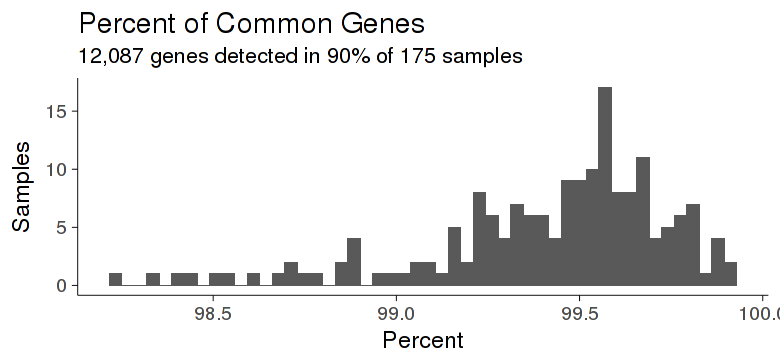

In [7]:
options(repr.plot.width = 6.5, repr.plot.height = 3)

ggplot(m, aes(x = 100 * common_percent, label = Sample)) +
geom_histogram(bins = 50) +
scale_y_continuous(breaks = scales::pretty_breaks(4)) +
labs(
  x = "Percent", y = "Samples", title = "Percent of Common Genes",
  subtitle = sprintf("%s genes detected in 90%% of %s samples", comma(length(common_genes)), nrow(m))
)

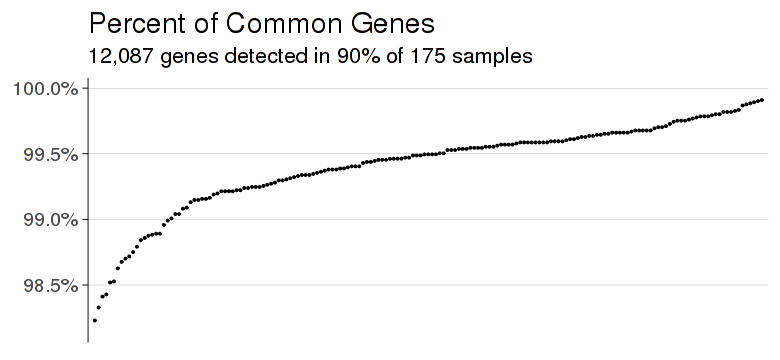

In [8]:
options(repr.plot.width = 6.5, repr.plot.height = 3)

ggplot(m, aes(reorder(Sample, common_percent), common_percent, label = Sample)) +
  geom_point(size = 0.05) +
#  geom_text(data = subset(n, common_percent < 0.9), hjust = -0.05, size = 6) +
#  geom_hline(yintercept = 0.9, color = "red", linetype = 2) +
  scale_y_continuous(labels = percent, expand = c(0.1, 0)) +
  scale_x_discrete(expand = c(0.01, 0)) +
  theme(
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank(),
    panel.grid.major.y = element_line(size = 0.03, color = 'black'),
    axis.line.x = element_blank()
  ) +
  labs(
    x = NULL, y = NULL, title = "Percent of Common Genes",
    subtitle = sprintf("%s genes detected in 90%% of %s samples", comma(length(common_genes)), nrow(m))
  )

In [9]:
log2tpm <- as.matrix(log2tpm)
log2tpm[1:5,1:5]

,1,10,100,101,103
ENSG00000000003,5.6368360,5.6120375,4.562725,4.816799,5.0516325
ENSG00000000419,6.1012522,6.4350168,5.998551,6.322659,6.4406239
ENSG00000000457,1.9274452,2.2781394,2.674104,2.358962,2.0489964
ENSG00000000460,2.2153369,2.3825649,3.839789,3.486106,3.3963727
ENSG00000000938,0.3855304,0.8894027,1.092442,0.000000,0.4897823


## Exclude lowly expressed genes

Let's compute some statistics on each gene:

In [10]:
gene_summary <- data.frame(
  mean = rowMeans(log2tpm),
  sd   = rowSds(log2tpm),
  samples = rowSums(log2tpm > 0)
)
gene_summary$mean_quantile <- rank(gene_summary$mean) / nrow(gene_summary)
gene_summary$sd_quantile <- rank(gene_summary$sd) / nrow(gene_summary)
gene_summary$density <- with(gene_summary, get_density(mean, sd))
gene_summary$gene <- gene_symbols[rownames(gene_summary)]
gene_summary$log10mean <- log10(gene_summary$mean)

Let's check some notable genes:

In [11]:
subset(gene_summary, gene %in% c("IL6", "CSF3", "ELF3", "NOS2"))

,mean,sd,samples,mean_quantile,sd_quantile,density,gene,log10mean
ENSG00000007171,0.4385086,0.699456,71,0.4282808,0.7827714,0.3857695030,NOS2,-0.3580219
ENSG00000108342,1.7908338,2.009895,102,0.6067432,0.9963668,0.0039719116,CSF3,0.2530553
ENSG00000136244,10.7486166,1.946072,175,0.9965485,0.9955312,0.0002700023,IL6,1.0313526
ENSG00000163435,2.2336959,1.353403,169,0.6422395,0.9797994,0.0179164602,ELF3,0.3490240


We see a nonlinear relationship between mean and standard deviation:

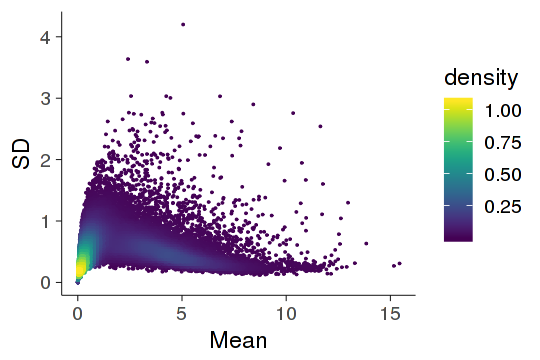

In [12]:
options(repr.plot.width = 4.5, repr.plot.height = 3)

ggplot(gene_summary[order(gene_summary$density),], aes(mean, sd, color = density)) +
scale_color_viridis() +
geom_point(size = 0.01) +
labs(x = "Mean", y = "SD")

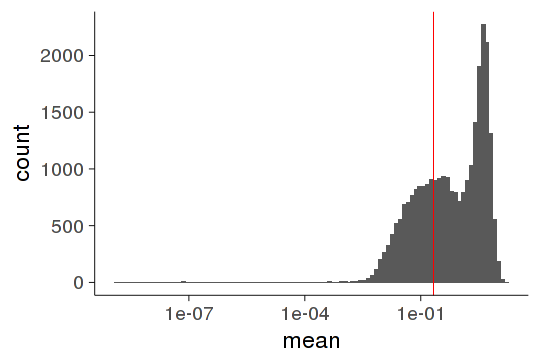

In [13]:
options(repr.plot.width = 4.5, repr.plot.height = 3)

ggplot(gene_summary, aes(x = mean)) +
geom_histogram(bins = 100) +
geom_vline(xintercept = quantile(gene_summary$mean, 0.33), size = 0.2, color = 'red') +
scale_x_log10()

In [14]:
0.1 * ncol(log2tpm)

[1] 17.5

Include genes that meet two criteria:

- At least 17 (10%) of samples have non-zero expression.
- The mean log2 TPM of the gene is greater than the 25 percentile.

In [15]:
gene_summary$include <- with(
  gene_summary,
  samples > 0.1 * ncol(log2tpm) & mean > quantile(mean, 0.25)
)

table(gene_summary$include)


FALSE  TRUE 
 7645 19879 

# Quality control: siRNA RNA-seq data

In [21]:
sirna$common_genes <- names(which(apply(sirna$log2tpm, 1, function(x) {
  sum(x > 0) > 0.9 * ncol(sirna$log2tpm)
})))

sirna$meta$common_percent <- apply(sirna$log2tpm[sirna$common_genes,], 2, function(x) {
  sum(x > 0) / length(sirna$common_genes)
})

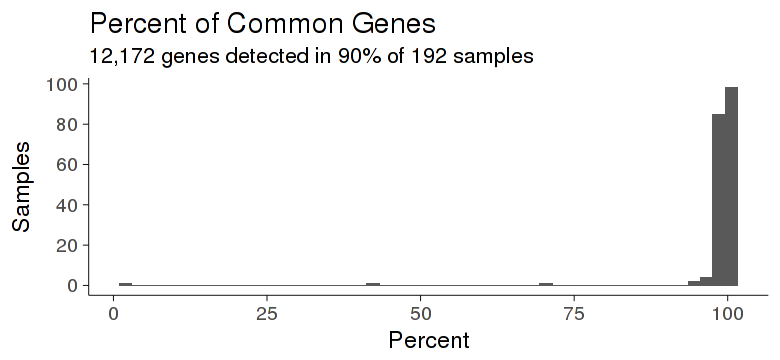

In [22]:
options(repr.plot.width = 6.5, repr.plot.height = 3)

ggplot(sirna$meta, aes(x = 100 * common_percent)) +
geom_histogram(bins = 50) +
scale_y_continuous(breaks = scales::pretty_breaks(4)) +
labs(
  x = "Percent", y = "Samples", title = "Percent of Common Genes",
  subtitle = sprintf(
    "%s genes detected in 90%% of %s samples",
    comma(length(sirna$common_genes)),
    nrow(sirna$meta)
  )
)

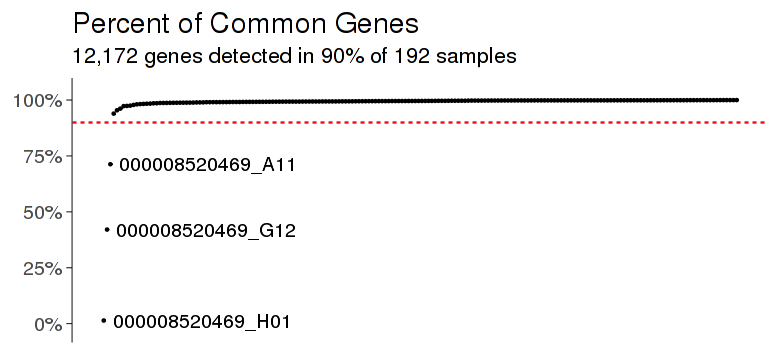

In [23]:
options(repr.plot.width = 6.5, repr.plot.height = 3)

ggplot(sirna$meta, aes(reorder(sample, common_percent), common_percent, label = sample)) +
  geom_point(size = 0.25) +
  geom_text(data = subset(sirna$meta, common_percent < 0.9), hjust = -0.05, size = 4) +
  geom_hline(yintercept = 0.9, color = "red", linetype = 2) +
  scale_y_continuous(labels = percent, expand = c(0.1, 0)) +
  scale_x_discrete(expand = c(0.05, 0)) +
  theme(
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_blank()
  ) +
  labs(
    x = NULL, y = NULL, title = "Percent of Common Genes",
    subtitle = sprintf(
      "%s genes detected in 90%% of %s samples",
      comma(length(sirna$common_genes)),
      nrow(sirna$meta)
    )
  )

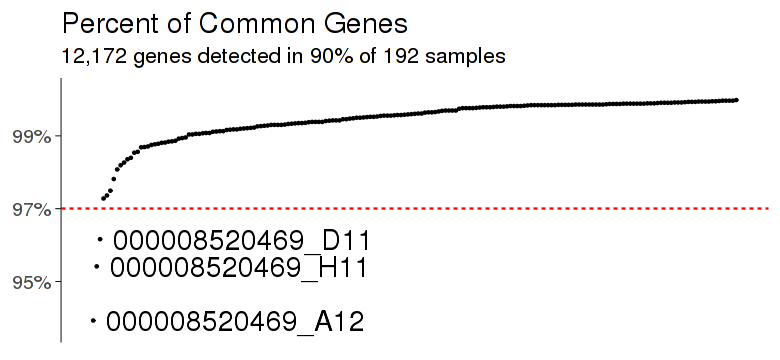

In [24]:
ggplot(subset(sirna$meta, common_percent > 0.9), aes(reorder(sample, common_percent), common_percent, label = sample)) +
  geom_point(size = 0.25) +
  geom_text(data = subset(sirna$meta, common_percent > 0.9 & common_percent < 0.97), hjust = -0.05, size = 6) +
  geom_hline(yintercept = 0.97, color = "red", linetype = 2) +
  scale_y_continuous(labels = percent, expand = c(0.1, 0)) +
  scale_x_discrete(expand = c(0.05, 0)) +
  theme(
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_blank()
  ) +
  labs(
    x = NULL, y = NULL, title = "Percent of Common Genes",
    subtitle = sprintf("%s genes detected in 90%% of %s samples", comma(length(sirna$common_genes)), nrow(sirna$meta))
  )

In [25]:
sirna$meta[sirna$meta$common_percent < 0.97,]

,sample,donor,sirna,time,stimulation,timefactor,dosefactor,common_percent
8,000008520469_H01,RA5,Ctrl,16,TNF (1) + IL17 (1),16,1,0.01413079
81,000008520469_A11,RA7,STAT3,0,None,0,0,0.71302990
84,000008520469_D11,RA7,STAT3,1,TNF (1) + IL17 (1),1,1,0.96163326
88,000008520469_H11,RA7,STAT3,16,TNF (1) + IL17 (1),16,1,0.95415708
89,000008520469_A12,RA7,STAT4,0,None,0,0,0.93928689
95,000008520469_G12,RA7,STAT4,16,TNF (1),16,0,0.42088400


In [26]:
ix <- sirna$meta$common_percent > 0.97
sirna$meta <- sirna$meta[ix,]
sirna$log2tpm <- sirna$log2tpm[,sirna$meta$sample]

In [27]:
dim(sirna$meta)
dim(sirna$log2tpm)

[1] 186   8

[1] 28888   186

In [28]:
sirna$log2tpm <- as.matrix(sirna$log2tpm)

## Exclude lowly expressed genes

Genes below the 25th quantile mean and standard deviation are excluded.

In [29]:
sirna$gene_summary <- data.frame(
  mean    = rowMeans(sirna$log2tpm),
  sd      = rowSds(sirna$log2tpm),
  samples = rowSums(sirna$log2tpm > 0)
)
sirna$gene_summary$mean_quantile <- rank(sirna$gene_summary$mean) / nrow(sirna$gene_summary)
sirna$gene_summary$sd_quantile <- rank(sirna$gene_summary$sd) / nrow(sirna$gene_summary)
sirna$gene_summary$density <- with(sirna$gene_summary, get_density(mean, sd))
sirna$gene_summary$gene <- gene_symbols[rownames(sirna$gene_summary)]
sirna$gene_summary$log10mean <- log10(sirna$gene_summary$mean)

In [30]:
names(gene_symbols[which(gene_symbols == "IL6")])

[1] "ENSG00000136244"

In [31]:
subset(sirna$gene_summary, gene == "IL6")

,mean,sd,samples,mean_quantile,sd_quantile,density,gene,log10mean
ENSG00000136244,6.590709,2.155578,186,0.9542371,0.9969884,0.0009912834,IL6,0.8189322


Include genes that meet two criteria:

- At least 17 (10%) of samples have non-zero expression.
- The mean log2 TPM of the gene is greater than the 33rd percentile.

In [32]:
sirna$gene_summary$include <- with(
  sirna$gene_summary,
  samples > 0.1 * ncol(sirna$log2tpm) & mean > quantile(mean, 0.25)
)

table(sirna$gene_summary$include)


FALSE  TRUE 
 8153 20735 

How many genes are included in both datasets?

In [33]:
length(intersect(
  rownames(sirna$log2tpm)[sirna$gene_summary$include],
  rownames(log2tpm)[gene_summary$include]
))

[1] 19278

# Exclude lowly expressed genes

Sanity check: Make sure *IL6* is included in the expression data before filtering.

In [38]:
names(gene_symbols[which(gene_symbols == "IL6")]) %in% rownames(log2tpm)
names(gene_symbols[which(gene_symbols == "IL6")]) %in% rownames(sirna$log2tpm)

[1] TRUE

[1] TRUE

In [39]:
subset(gene_summary, gene %in% c("CSF3", "IL6", "CXCL8", "NOS2"))

,mean,sd,samples,mean_quantile,sd_quantile,density,gene,log10mean,include
ENSG00000007171,0.4385086,0.699456,71,0.4282808,0.7827714,0.3857695030,NOS2,-0.3580219,TRUE
ENSG00000108342,1.7908338,2.009895,102,0.6067432,0.9963668,0.0039719116,CSF3,0.2530553,TRUE
ENSG00000136244,10.7486166,1.946072,175,0.9965485,0.9955312,0.0002700023,IL6,1.0313526,TRUE
ENSG00000169429,11.6408935,2.540853,172,0.9988010,0.9990917,0.0002789346,CXCL8,1.0659863,TRUE


In [40]:
dim(log2tpm)

log2tpm <- log2tpm[gene_summary$include,]

dim(log2tpm)

[1] 27524   175

[1] 19879   175

In [41]:
dim(sirna$log2tpm)

sirna$log2tpm <- sirna$log2tpm[sirna$gene_summary$include,]

dim(sirna$log2tpm)

[1] 28888   186

[1] 20735   186

In [42]:
all(colnames(log2tpm) == m$Sample)
all(colnames(sirna$log2tpm) == sirna$meta$Sample)

[1] TRUE

[1] TRUE

In [43]:
meta <- m

# Export for shiny

In [44]:
save(
  list = c("log2tpm", "meta", "gene_symbols", "meta_colors", "gene_summary"),
  file = "data/shiny_rnaseq.rda"
)

In [45]:
save(
  list = c("log2tpm", "meta", "gene_summary"),
  envir = sirna,
  file = "data/shiny_rnaseq-sirna.rda"
)